Checking the accuracy of the algorithmic tracking

In [9]:
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl

In [10]:
# Load data

# Load data from algorithmic tracking
raterFiles = glob.glob("data/P*.txt")
df_algoFiles = (pd.read_csv(f, header = None) for f in raterFiles)
df_algo   = pd.concat(df_algoFiles, ignore_index=True, axis = 0)

# Load data from manual ratings
raterFiles = glob.glob("data/data_Rater*.csv")
df_raterFiles = (pd.read_csv(f, header = 0) for f in raterFiles)
df_rater   = pd.concat(df_raterFiles, ignore_index=True)

In [11]:
# Prepare data

# Only take the last judgement of each rater
df_rater.drop_duplicates(subset=['Rater', 'Frame', 'Trial'], keep='last', inplace = True)

# Rename columns
df_algo.columns = ["Trial", "AOI", "1", "2", "3", "4", "5", "6", "VisiblePoints", "7", "8" ]

# Add frame number column
df_algo["Frame"] = df_algo.groupby(['Trial']).cumcount()
# df_rater["Frame_guess"] = df_rater.groupby(['Trial', 'Rater']).cumcount()

# Set datatypes
df_algo["Trial"] = df_algo["Trial"].astype("string")
df_algo["Frame"] = df_algo["Frame"].astype("string")
df_algo["AOI"] = df_algo["AOI"].astype("string")
df_rater["Frame"] = df_rater["Frame"].astype("string")
df_rater["Trial"] = df_rater["Trial"].astype("string")
df_rater["Label"] = df_rater["Label"].astype("string")


In [12]:
# Rename the labels to match the AOI from the algorithmic approach
df_algo['AOI'] = df_algo['AOI'].str.replace("Nose","Head")
df_algo['AOI'] = df_algo['AOI'].str.replace("Neck","Chest")
df_algo['AOI'] = df_algo['AOI'].str.replace("LElbow","Left arm")
df_algo['AOI'] = df_algo['AOI'].str.replace("RElbow","Right arm")
df_algo['AOI'] = df_algo['AOI'].str.replace("RKnee","Right leg")
df_algo['AOI'] = df_algo['AOI'].str.replace("LKnee","Left leg")
df_algo['AOI'] = df_algo['AOI'].str.replace("MidHip","Pelvis")

# Check the unique values
df_algo['AOI'].unique()


<StringArray>
[    'Other',      'Head', 'Right arm',     'Chest',    'Pelvis',  'Left arm',
  'Left leg', 'Right leg']
Length: 8, dtype: string

In [13]:
# Merge data frames

# merge on trial and frame
df = pd.merge(df_algo, df_rater, how = 'inner', on = ["Trial", "Frame"])

In [14]:
# Get percentage of correctly identified frames
df['Correct'] = df.AOI == df.Label

# Only keep interesting columns
df.drop(columns=["1", "2", "3", "4", "5", "6", "7", "8"], inplace = True)

# Subset the other column (Others are not relevant)
df = df[df.AOI != "Other"]
df = df[df.Label != "Other"]

df_rater1 = df[df.Rater == "Rater1"]
df_rater2 = df[df.Rater == "Rater2"]
df_rater3 = df[df.Rater == "Rater3"]

# Total correct
print(df.Correct.sum() / len(df.Correct))

# Rater 1 correct
print(df_rater1.Correct.sum() / len(df_rater1.Correct))
print(df_rater2.Correct.sum() / len(df_rater2.Correct))
print(df_rater3.Correct.sum() / len(df_rater3.Correct))



0.7953132472501195
0.8646723646723646
0.7151079136690648
0.8054755043227666


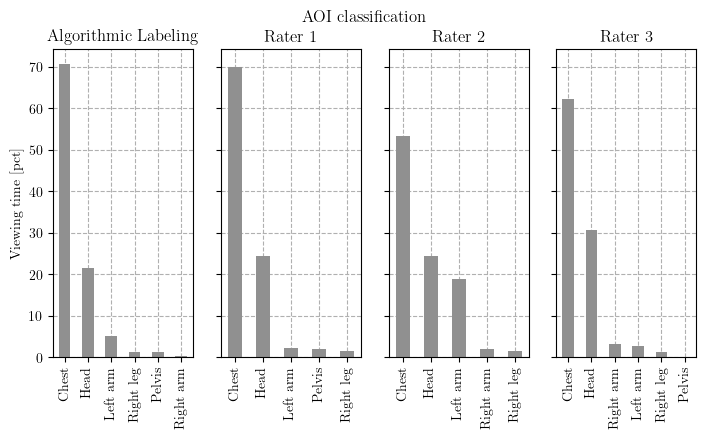

In [73]:
%matplotlib inline
mpl.style.use('default')

# The data
pct_algorithm = (df.loc[df.Rater == "Rater1", 'AOI'].value_counts() / df.loc[df.Rater == "Rater1"].shape[0]) * 100
pct_rater1 = (df.loc[df.Rater == "Rater1", 'Label'].value_counts() / df.loc[df.Rater == "Rater1"].shape[0]) * 100
pct_rater2 = (df.loc[df.Rater == "Rater2", 'Label'].value_counts() / df.loc[df.Rater == "Rater2"].shape[0]) * 100
pct_rater3 = (df.loc[df.Rater == "Rater3", 'Label'].value_counts() / df.loc[df.Rater == "Rater3"].shape[0]) * 100

# Plot settings
# Requires on linux: sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
mpl.rcParams.update(
    {
        'font.family': 'serif',
        'text.usetex': True,
    }
)

# Figure settings for export
pts_document_with = 600. # How wide is the page
pts_per_inch = 1. / 72.27
figure_width = pts_document_with * pts_per_inch

# Plot
fig, axes = plt.subplots(nrows=1, ncols=4, figsize = (figure_width,4), sharey = True)

axes[0].set_axisbelow(True)
axes[1].set_axisbelow(True)
axes[2].set_axisbelow(True)
axes[3].set_axisbelow(True)

pct_algorithm.plot(kind = 'bar', ax = axes[0], color = '#909090')
pct_rater1.plot(kind = 'bar', ax = axes[1], color = '#909090')
pct_rater2.plot(kind = 'bar', ax = axes[2], color = '#909090')
pct_rater3.plot(kind = 'bar', ax = axes[3], color = '#909090')

axes[0].grid(linestyle='dashed')
axes[1].grid(linestyle='dashed')
axes[2].grid(linestyle='dashed')
axes[3].grid(linestyle='dashed')

fig.suptitle("AOI classification")
axes[0].set_ylabel("Viewing time [pct]")
axes[0].set_title("Algorithmic Labeling")
axes[1].set_title("Rater 1")
axes[2].set_title("Rater 2")
axes[3].set_title("Rater 3")

# Save
plt.savefig("RaterComparison.svg", bbox_inches='tight')

In [ ]:
# Plot the agreement per trial
